# [DGL at a Glance¶](https://docs.dgl.ai/en/0.6.x/tutorials/basics/1_first.html)

+ “Zachary’s karate club” problem
  + ふたつの流派に分裂した空手について分析する．

In [1]:
import dgl
import numpy as np

def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.graph((u, v))

In [2]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


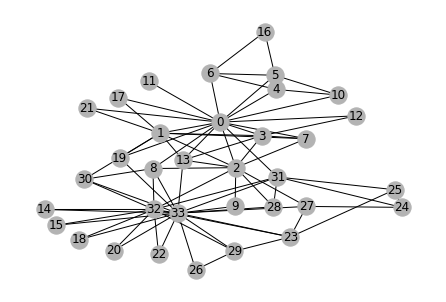

In [3]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [4]:
# In DGL, you can add features for all nodes at once, using a feature tensor that
# batches node features along the first dimension. The code below adds the learnable
# embeddings for all nodes:

import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

In [5]:
# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([ 1.4983, -0.5508, -0.3717, -0.8056,  0.7575],
       grad_fn=<SelectBackward0>)
tensor([[ 0.6983,  0.4831,  1.5290,  0.6108,  0.9982],
        [ 0.0965, -0.1104, -0.7999, -1.2563,  1.8010]],
       grad_fn=<IndexBackward0>)


In [6]:
# GraphConvは隣接したノードからの情報を非線形変換によって次のレイヤーに渡す．
from dgl.nn.pytorch import GraphConv

In [7]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

In [9]:
# semi-unsupervidesなので入力はそのままにしておく
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [10]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7100
Epoch 1 | Loss: 0.6903
Epoch 2 | Loss: 0.6729
Epoch 3 | Loss: 0.6589
Epoch 4 | Loss: 0.6467
Epoch 5 | Loss: 0.6348
Epoch 6 | Loss: 0.6219
Epoch 7 | Loss: 0.6083
Epoch 8 | Loss: 0.5946
Epoch 9 | Loss: 0.5801
Epoch 10 | Loss: 0.5651
Epoch 11 | Loss: 0.5490
Epoch 12 | Loss: 0.5322
Epoch 13 | Loss: 0.5149
Epoch 14 | Loss: 0.4971
Epoch 15 | Loss: 0.4786
Epoch 16 | Loss: 0.4596
Epoch 17 | Loss: 0.4401
Epoch 18 | Loss: 0.4204
Epoch 19 | Loss: 0.4007
Epoch 20 | Loss: 0.3812
Epoch 21 | Loss: 0.3615
Epoch 22 | Loss: 0.3415
Epoch 23 | Loss: 0.3213
Epoch 24 | Loss: 0.3012
Epoch 25 | Loss: 0.2809
Epoch 26 | Loss: 0.2605
Epoch 27 | Loss: 0.2402
Epoch 28 | Loss: 0.2203
Epoch 29 | Loss: 0.2011
Epoch 30 | Loss: 0.1827
Epoch 31 | Loss: 0.1651
Epoch 32 | Loss: 0.1485
Epoch 33 | Loss: 0.1330
Epoch 34 | Loss: 0.1186
Epoch 35 | Loss: 0.1054
Epoch 36 | Loss: 0.0934
Epoch 37 | Loss: 0.0824
Epoch 38 | Loss: 0.0726
Epoch 39 | Loss: 0.0638
Epoch 40 | Loss: 0.0560
Epoch 41 | Loss: 0.0491
Ep